## Implementation with FLOWER

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [148]:
plt.rcParams["figure.figsize"] = (25,15)

In [149]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [150]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [151]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [152]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [153]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [154]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [155]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [156]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [157]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
timesteps = 13 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14078, 13, 1)

In [159]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [171]:
# Training
history= model.fit(X_train, y_train, epochs=110, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 2/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 3/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 4/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 6ms/step
Epoch 5/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 6/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 7/110
587/587 - 2s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 2s/epoch - 4ms/step
Epoch 8/110
587/587 - 2s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 2s/epoch - 4ms/step
Epoch 9/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/

In [172]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

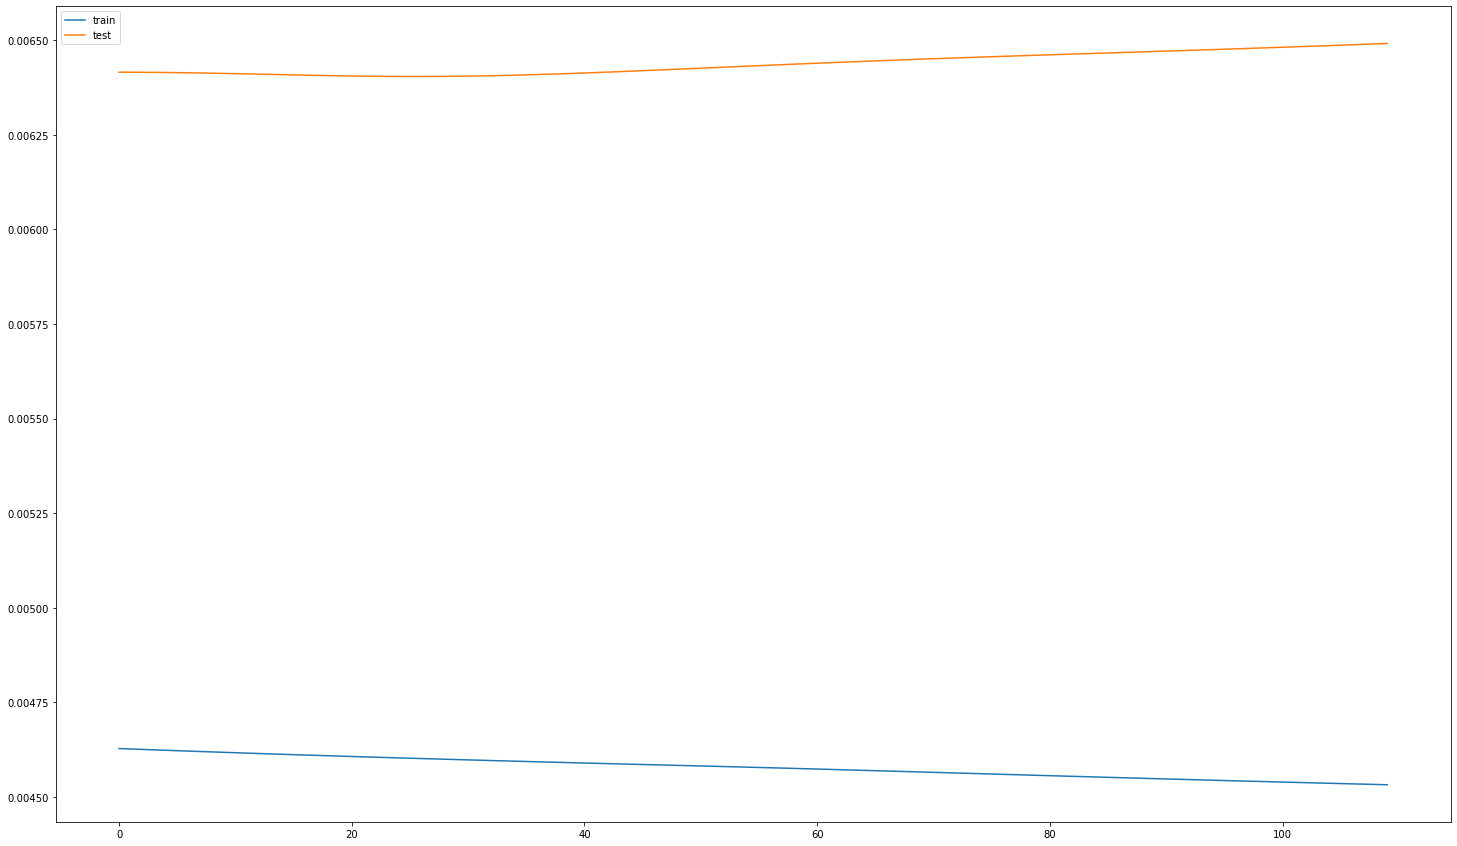

In [174]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

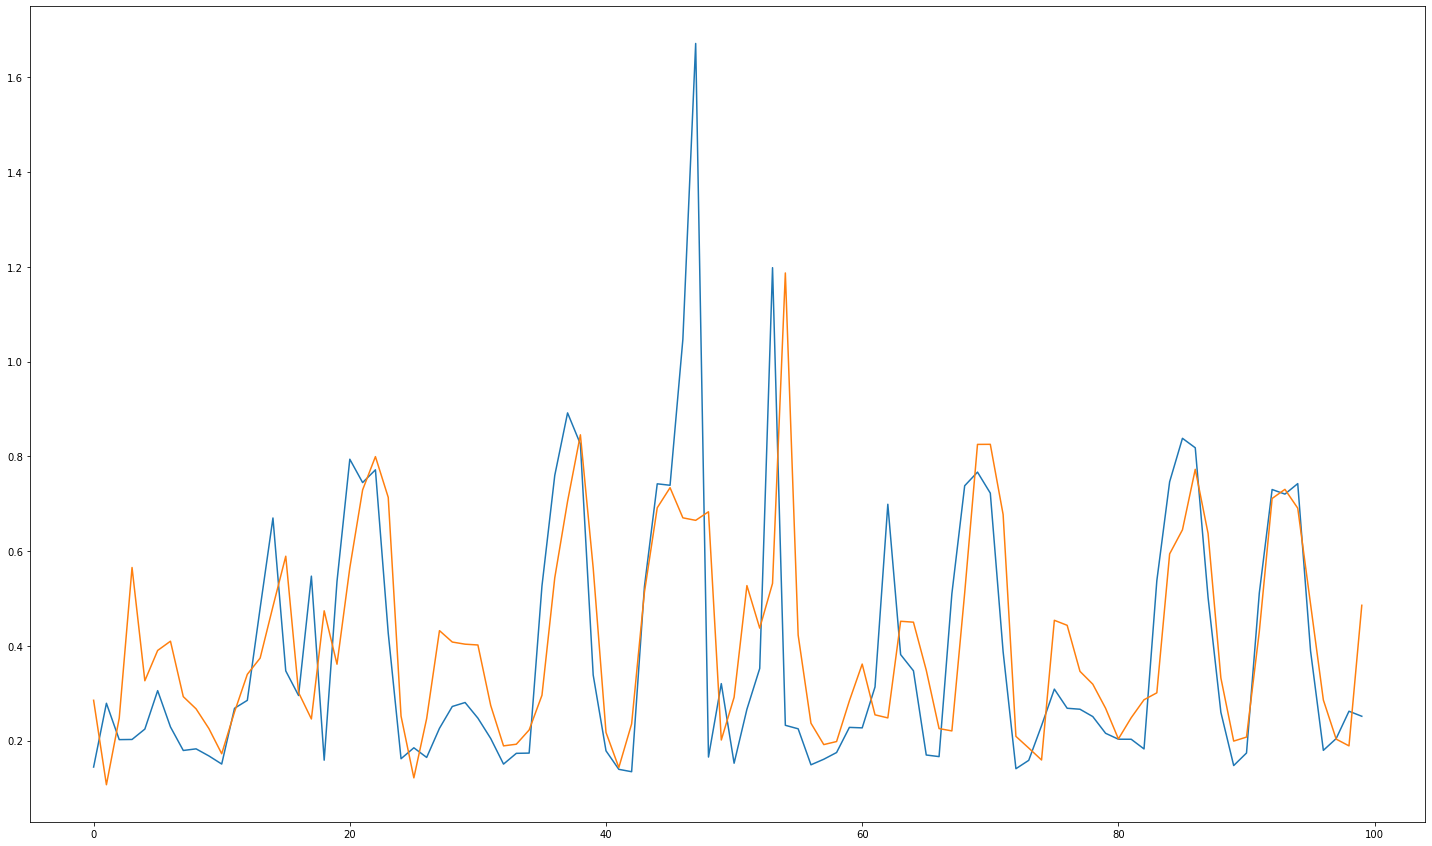

In [181]:
# plt.plot(pred_train['true'])
# plt.plot(pred_train['simple_lstm'])

plt.plot(pred_test['true'][0:100])
plt.plot(pred_test['simple_lstm'][0:100])
plt.show()


In [182]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [183]:
rmse_train={}
rmse_test={}

In [184]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [188]:
rmse_test

{'naive': 0.2583147014240696}

In [315]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [316]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [317]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [189]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [190]:
train, test = scale(train, test)

In [191]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [192]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [193]:
history1=stateless_multilayer.fit(X_train, y_train, batch_size=24,epochs=50, validation_split=0.3 )

Epoch 1/50
411/411 [==============================] - 8s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2/50
411/411 [==============================] - 5s 11ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
411/411 [==============================] - 5s 11ms/step - 

In [194]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

In [204]:
pred_test = pd.DataFrame(pred_test)

<AxesSubplot:>

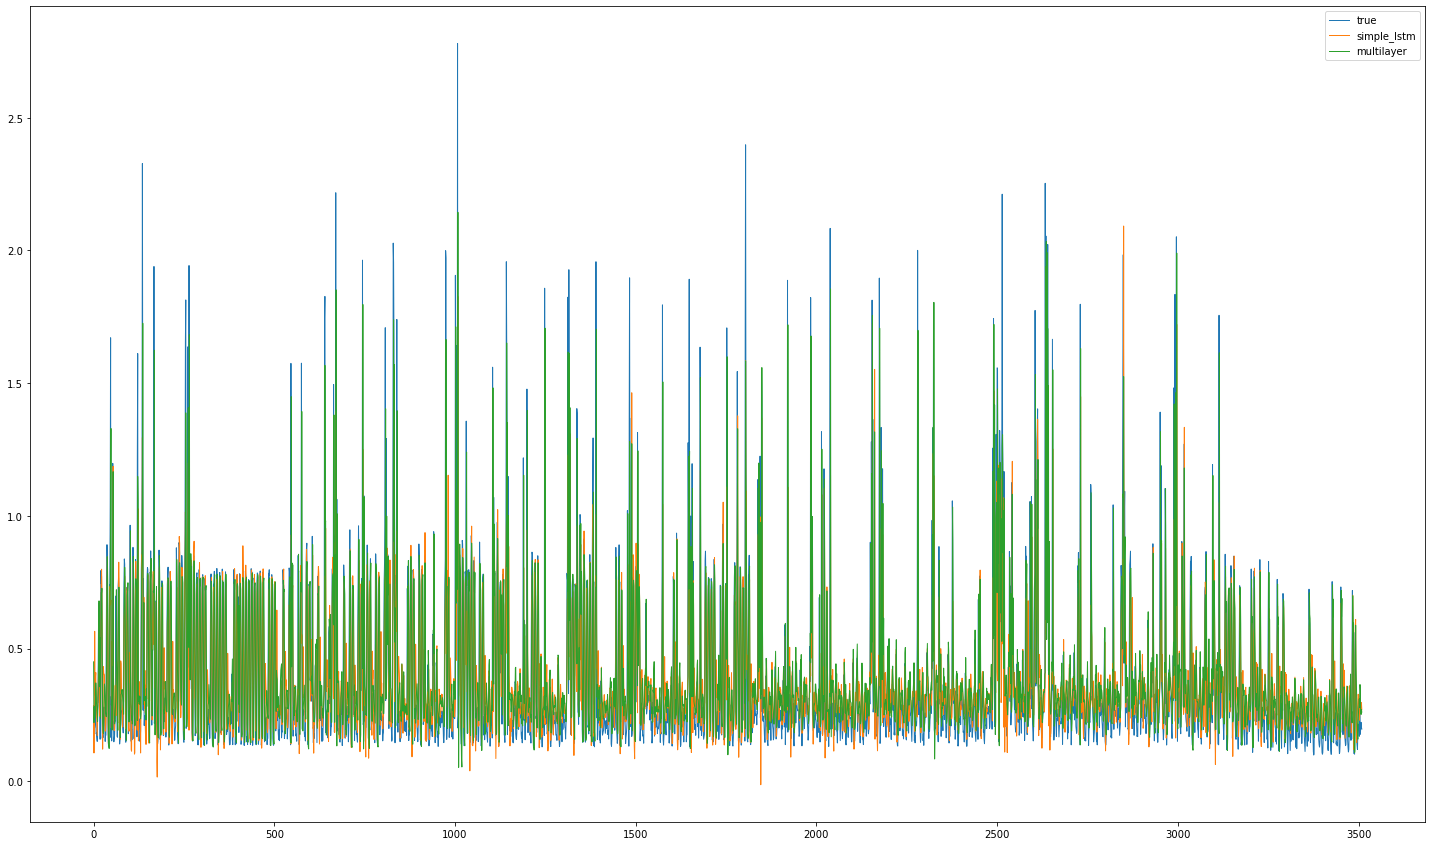

In [202]:
pd.DataFrame(pred_test).plot(lw=1)

In [196]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [197]:
rmse_train

{'naive': 0.2290306977116612, 'stateless_multilayer': 0.23954870727576888}

In [198]:
rmse_test

{'naive': 0.2583147014240696, 'stateless_multilayer': 0.28528711404753293}

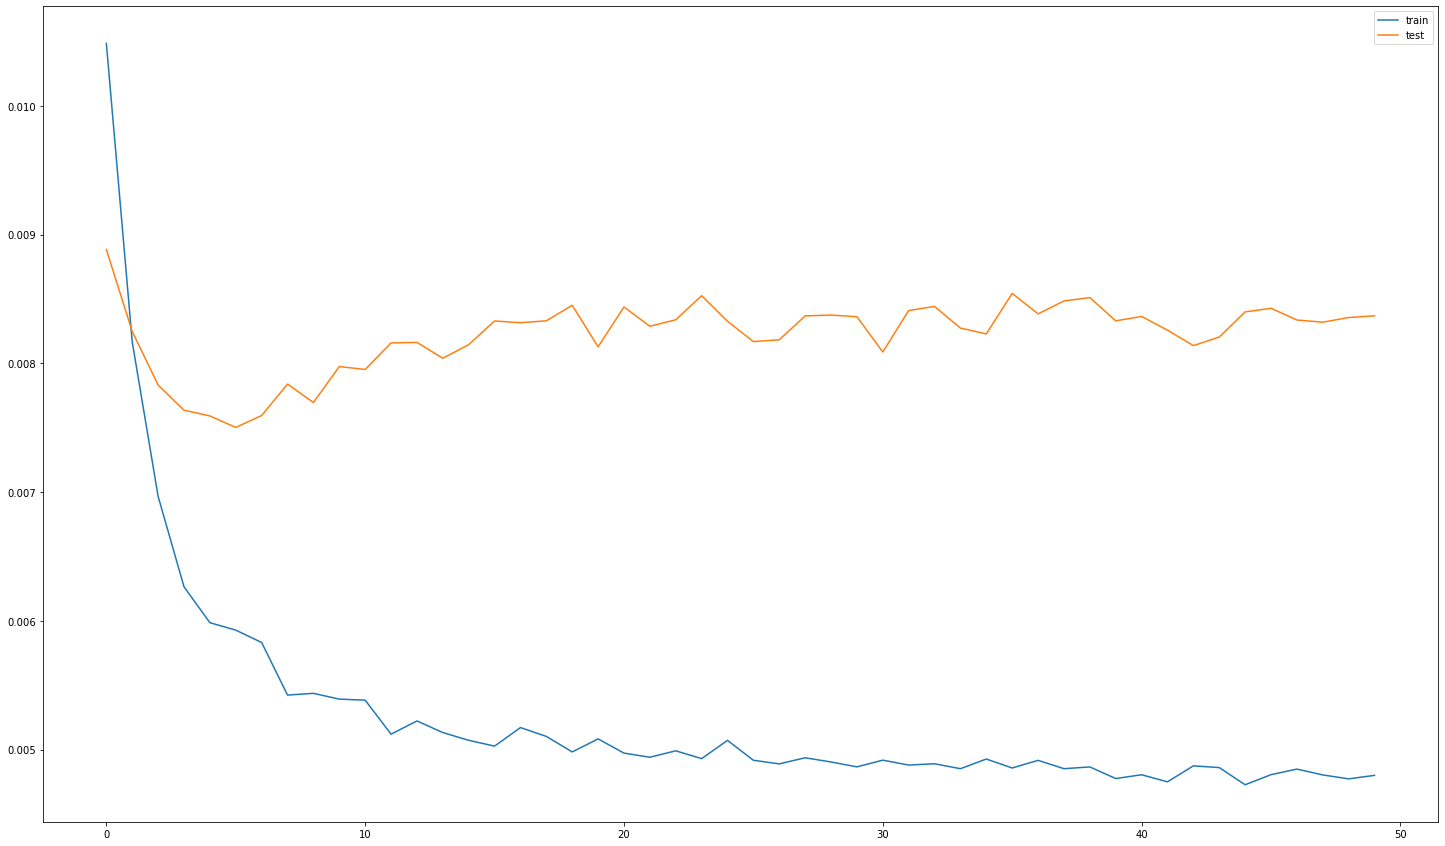

In [199]:
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

### Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [217]:
example = homes

In [218]:
example

,total_a,total_b,total_c,total_d,total_f,total_g,total_h
Date & Time,,,,,,,
2014-01-01 00:00:00,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
2014-01-01 01:00:00,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2014-01-01 02:00:00,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
2014-01-01 03:00:00,NaN,1.910317,2.223021,NaN,1.549448,NaN,NaN
2014-01-01 04:00:00,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
2016-12-31 20:00:00,0.199725,NaN,NaN,8.362464,1.439440,0.234510,NaN
2016-12-31 21:00:00,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN


In [219]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [223]:
values

array([[       nan, 1.6768433 , 2.6898198 , ..., 2.0605714 ,        nan,
               nan],
       [       nan, 2.1671565 , 1.5183908 , ..., 1.2129117 ,        nan,
               nan],
       [       nan, 1.1024139 , 1.963862  , ..., 1.3428358 ,        nan,
               nan],
       ...,
       [0.22226584,        nan,        nan, ..., 1.4108745 , 0.27891833,
               nan],
       [0.20390445,        nan,        nan, ..., 0.9754361 , 0.10621889,
               nan],
       [0.19684666,        nan,        nan, ..., 0.5764903 , 0.10647195,
               nan]], dtype=float32)

In [224]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [225]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [27]:
# # drop columns we don't want to predict
# reframed =reframed.iloc[:,:-6]

In [226]:
reframed

,home_1(t-1),home_2(t-1),home_3(t-1),home_4(t-1),home_5(t-1),home_6(t-1),home_7(t-1),home_1(t),home_2(t),home_3(t),home_4(t),home_5(t),home_6(t),home_7(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
1,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
3,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN
4,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.263403,NaN,NaN,7.307169,1.542869,0.184146,NaN,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
35060,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN
35061,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN
35062,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN,0.203904,NaN,NaN,6.726995,0.975436,0.106219,NaN


In [503]:
# reframed= reframed.iloc[1:,:]

In [227]:
itercols = [col for col in reframed.columns if '(t)' in col]
cols1 = [col for col in reframed.columns if '(t-' in col]

In [96]:
cols1.append(itercols[1])
list1 = []
list1.append(cols1)

In [102]:
list1 =[]
for i in range(0,len(itercols)):
    cols1.append(itercols[i])
    list1.append(cols1)

In [228]:
home_b = reframed.iloc[:,[1,2,4,8]]

<AxesSubplot:>

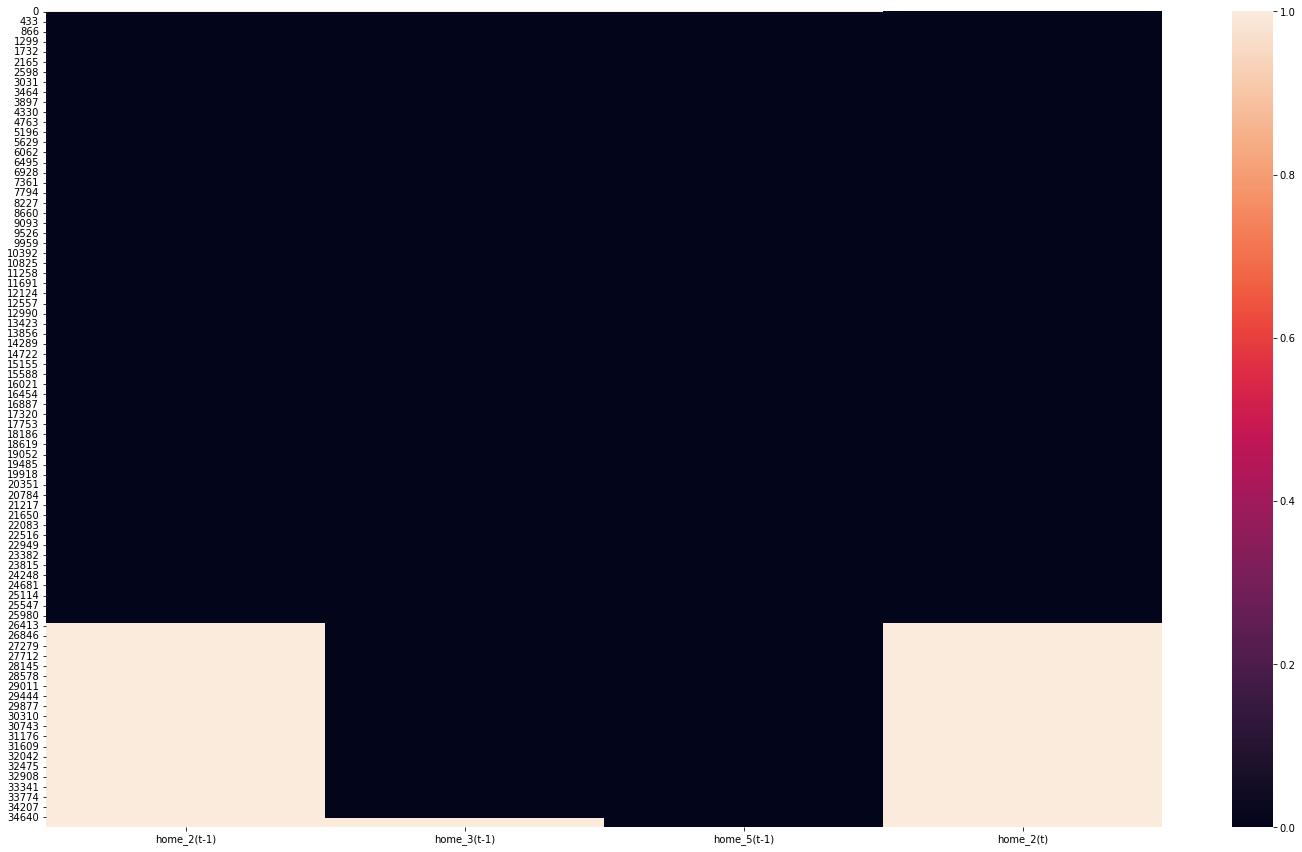

In [229]:
import seaborn as sns
sns.heatmap(home_b.isna())

In [230]:
home_b= home_b.dropna()

In [231]:
# split into train and test sets
values = home_b.values

train, test = train_test_split(values, train_size=0.9, shuffle=False)


In [247]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [248]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23651, 1, 3) (23651,) (2628, 1, 3) (2628,)


In [250]:
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [251]:
# fit network
history2 = model.fit(X_train, y_train, epochs=50, batch_size=24, verbose=2, shuffle=False)


Epoch 1/50
986/986 - 4s - loss: 0.0352 - 4s/epoch - 4ms/step
Epoch 2/50
986/986 - 3s - loss: 0.0334 - 3s/epoch - 3ms/step
Epoch 3/50
986/986 - 3s - loss: 0.0334 - 3s/epoch - 3ms/step
Epoch 4/50
986/986 - 3s - loss: 0.0333 - 3s/epoch - 3ms/step
Epoch 5/50
986/986 - 3s - loss: 0.0333 - 3s/epoch - 3ms/step
Epoch 6/50
986/986 - 4s - loss: 0.0333 - 4s/epoch - 4ms/step
Epoch 7/50
986/986 - 3s - loss: 0.0332 - 3s/epoch - 3ms/step
Epoch 8/50
986/986 - 3s - loss: 0.0333 - 3s/epoch - 3ms/step
Epoch 9/50
986/986 - 4s - loss: 0.0332 - 4s/epoch - 4ms/step
Epoch 10/50
986/986 - 3s - loss: 0.0333 - 3s/epoch - 3ms/step
Epoch 11/50
986/986 - 3s - loss: 0.0332 - 3s/epoch - 3ms/step
Epoch 12/50
986/986 - 4s - loss: 0.0332 - 4s/epoch - 4ms/step
Epoch 13/50
986/986 - 4s - loss: 0.0332 - 4s/epoch - 4ms/step
Epoch 14/50
986/986 - 3s - loss: 0.0331 - 3s/epoch - 3ms/step
Epoch 15/50
986/986 - 2s - loss: 0.0332 - 2s/epoch - 3ms/step
Epoch 16/50
986/986 - 3s - loss: 0.0332 - 3s/epoch - 3ms/step
Epoch 17/50
986/9

KeyError: 'val_loss'

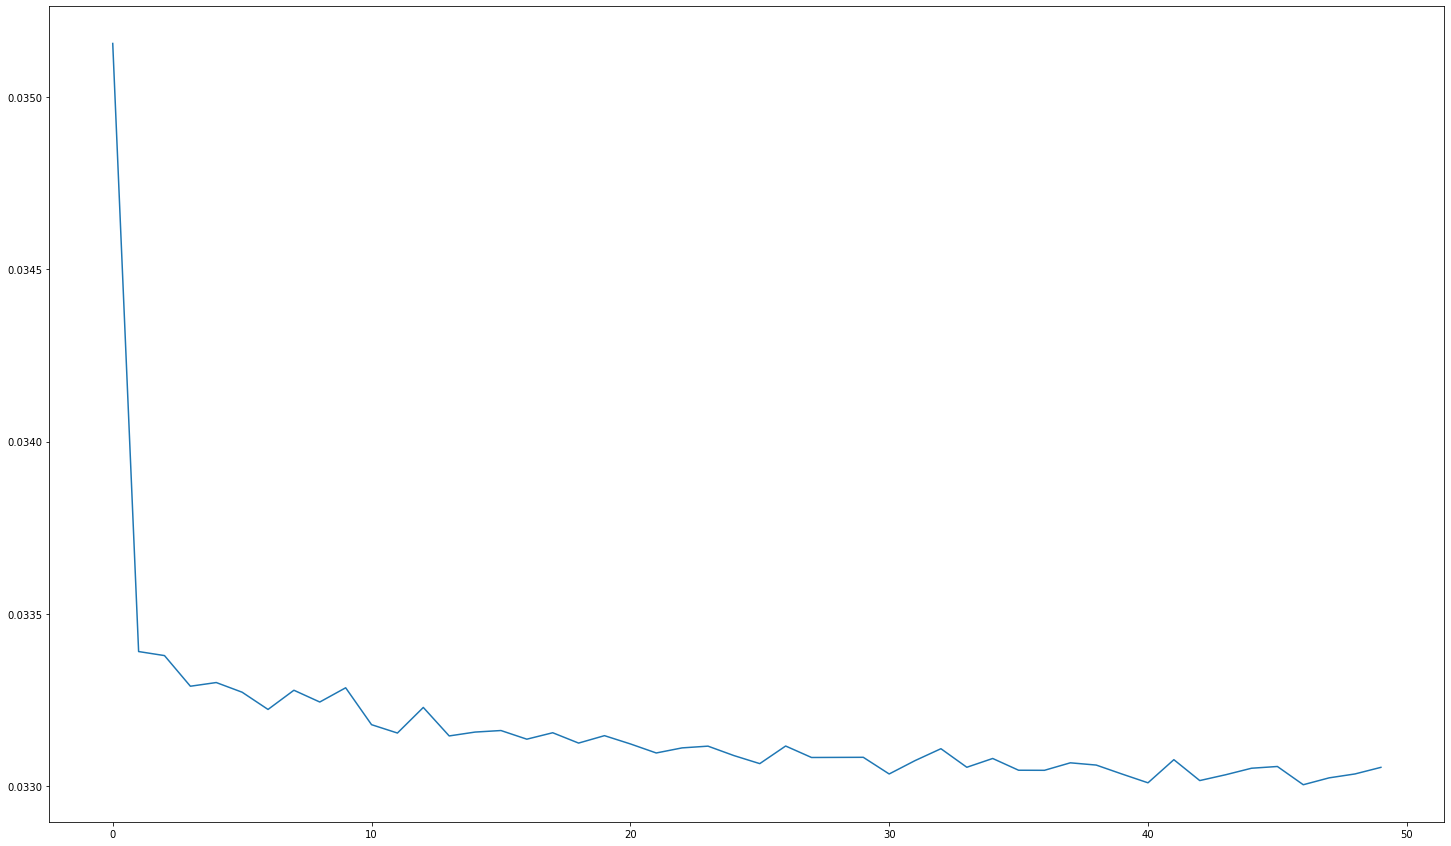

In [252]:
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [262]:
# Evaluate the model

X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [280]:
y_train= y_train.reshape(len(y_train),1)

In [266]:
pred_b_train ={}
pred_b_test = {}

pred_b_train["true"] = scaler.inverse_transform(y_train) # store as 1d array


ValueError: Expected 2D array, got 1D array instead:
array=[0.11601688 0.05901679 0.10226721 ... 0.10083045 0.08723431 0.08723431].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
pred_b_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_b_train["dense_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_b_test['dense_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

In [269]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((test_y, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.694


In [273]:
len(inv_yhat)
len(inv_y)

2628

In [275]:
rmse(inv_y, inv_yhat)

TypeError: 'numpy.float32' object is not callable